# Cohort 9

## Effect of different initial bias settings for relu

In [1]:
import sys
sys.path.append('../..')
from deep_bottleneck.eval_tools.experiment_loader import ExperimentLoader
from deep_bottleneck.eval_tools.utils import format_config, find_differing_config_keys
import matplotlib.pyplot as plt
from io import BytesIO

import pandas as pd
import numpy as np

In [2]:
loader = ExperimentLoader()

In [3]:
experiment_ids = [862, 859, 860, 868, 867, 863, 864, 866, 861, 865, 869, 870]
experiments = loader.find_by_ids(experiment_ids)
differing_config_keys = find_differing_config_keys(experiments)

For this experiment we varied the initial bias parameter of the hidden layers with an otherwise standard setting of the parameters under a `relu` activation function. Varying the initial bias it interesting, as this shifts the preactivation of the layers by the specified bias `output = activation(dot(input, kernel) + bias)`. This, in turn, affects the proportion of preactivations that end up in the saturation regime of the respective activation function. We hypothesize therefore that the inital bias can have an effect on the compression of a layer. In the case of `relu`, when the `initial_bias=0`, approximately half of the preactivations are negative and mapped to `0`. This induces "immediate" compression, as it was discussed for example in notebook `9.analyze_entropy`. By shifting the preactivations with the (positive) initial_bias parameter, we can supress immediate compression. Below the informationplane plots for different settings of the initial bias parameter are shown. 

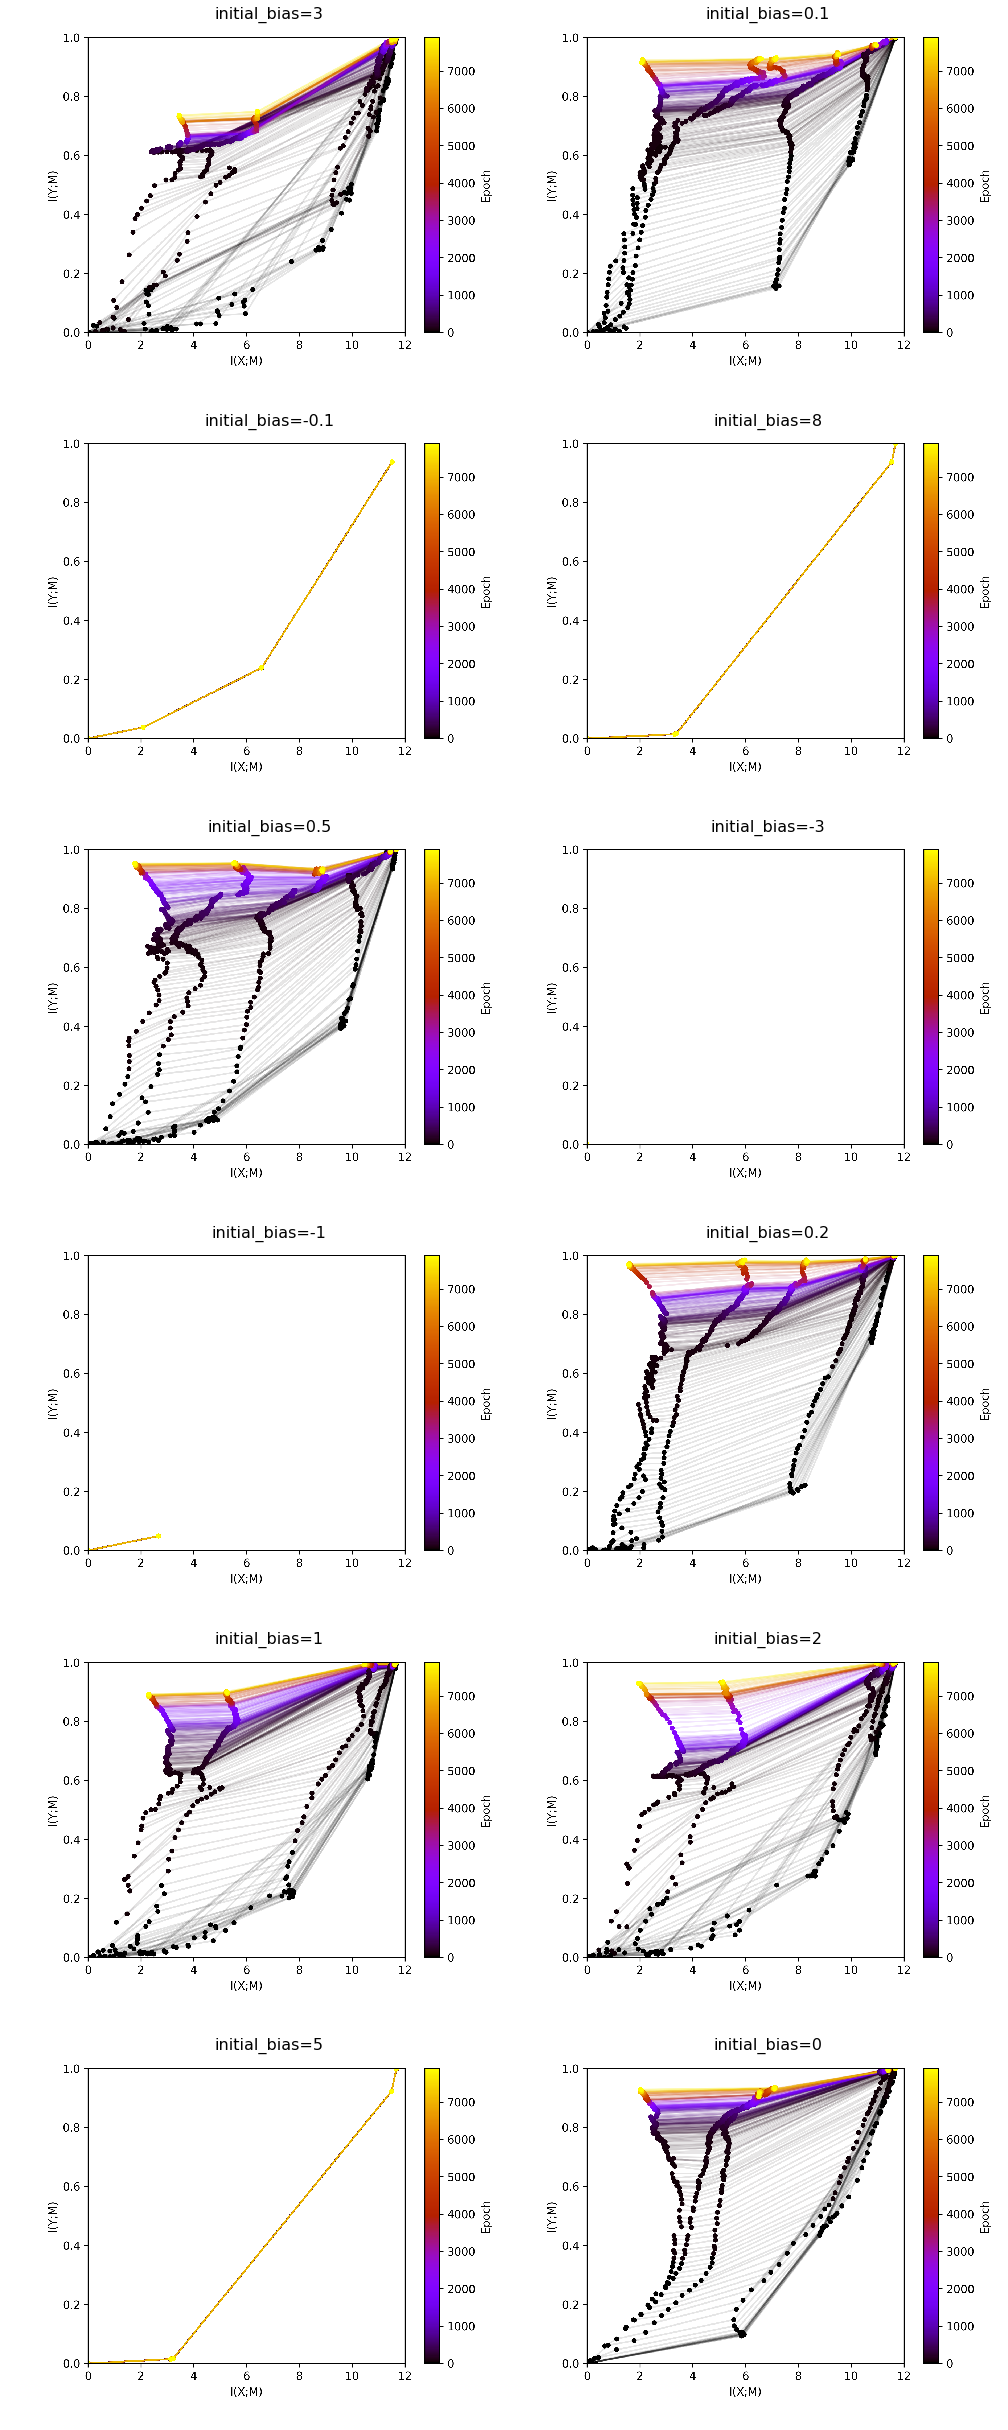

In [7]:
fig, ax = plt.subplots(6,2, figsize=(14, 34))
ax = ax.flat

for i, experiment in enumerate(experiments):
    img = plt.imread(BytesIO(experiment.artifacts['infoplane_train'].content))
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title(format_config(experiment.config, *differing_config_keys),
                    fontsize=16)
plt.tight_layout()    
plt.show()

The informationplane plots shows two qualitaively different patterns. For negative initial bias settings as well as for initial bias settings wth large positive magnitude all gradients remain 0 for the entire training process, therefore not changing any weights in the network. In this setting mutual information of the resepctive layers stays constant over the entire process. Here, we only look at informationplane plots that show a some dynamic of the mutual inforamtion values over time, with `inital_bias=0` as a reference. For the penultimate layer and `initial_bias=0.2, 1 and 2` we can observe a decrease in mutual information with the input in the later stages of training (from epoch 1000 onwards). Does this movement towards the upper left in the information plane correspond to the network gradually learning weights and biases which push activations towards the neagtive spectrum?

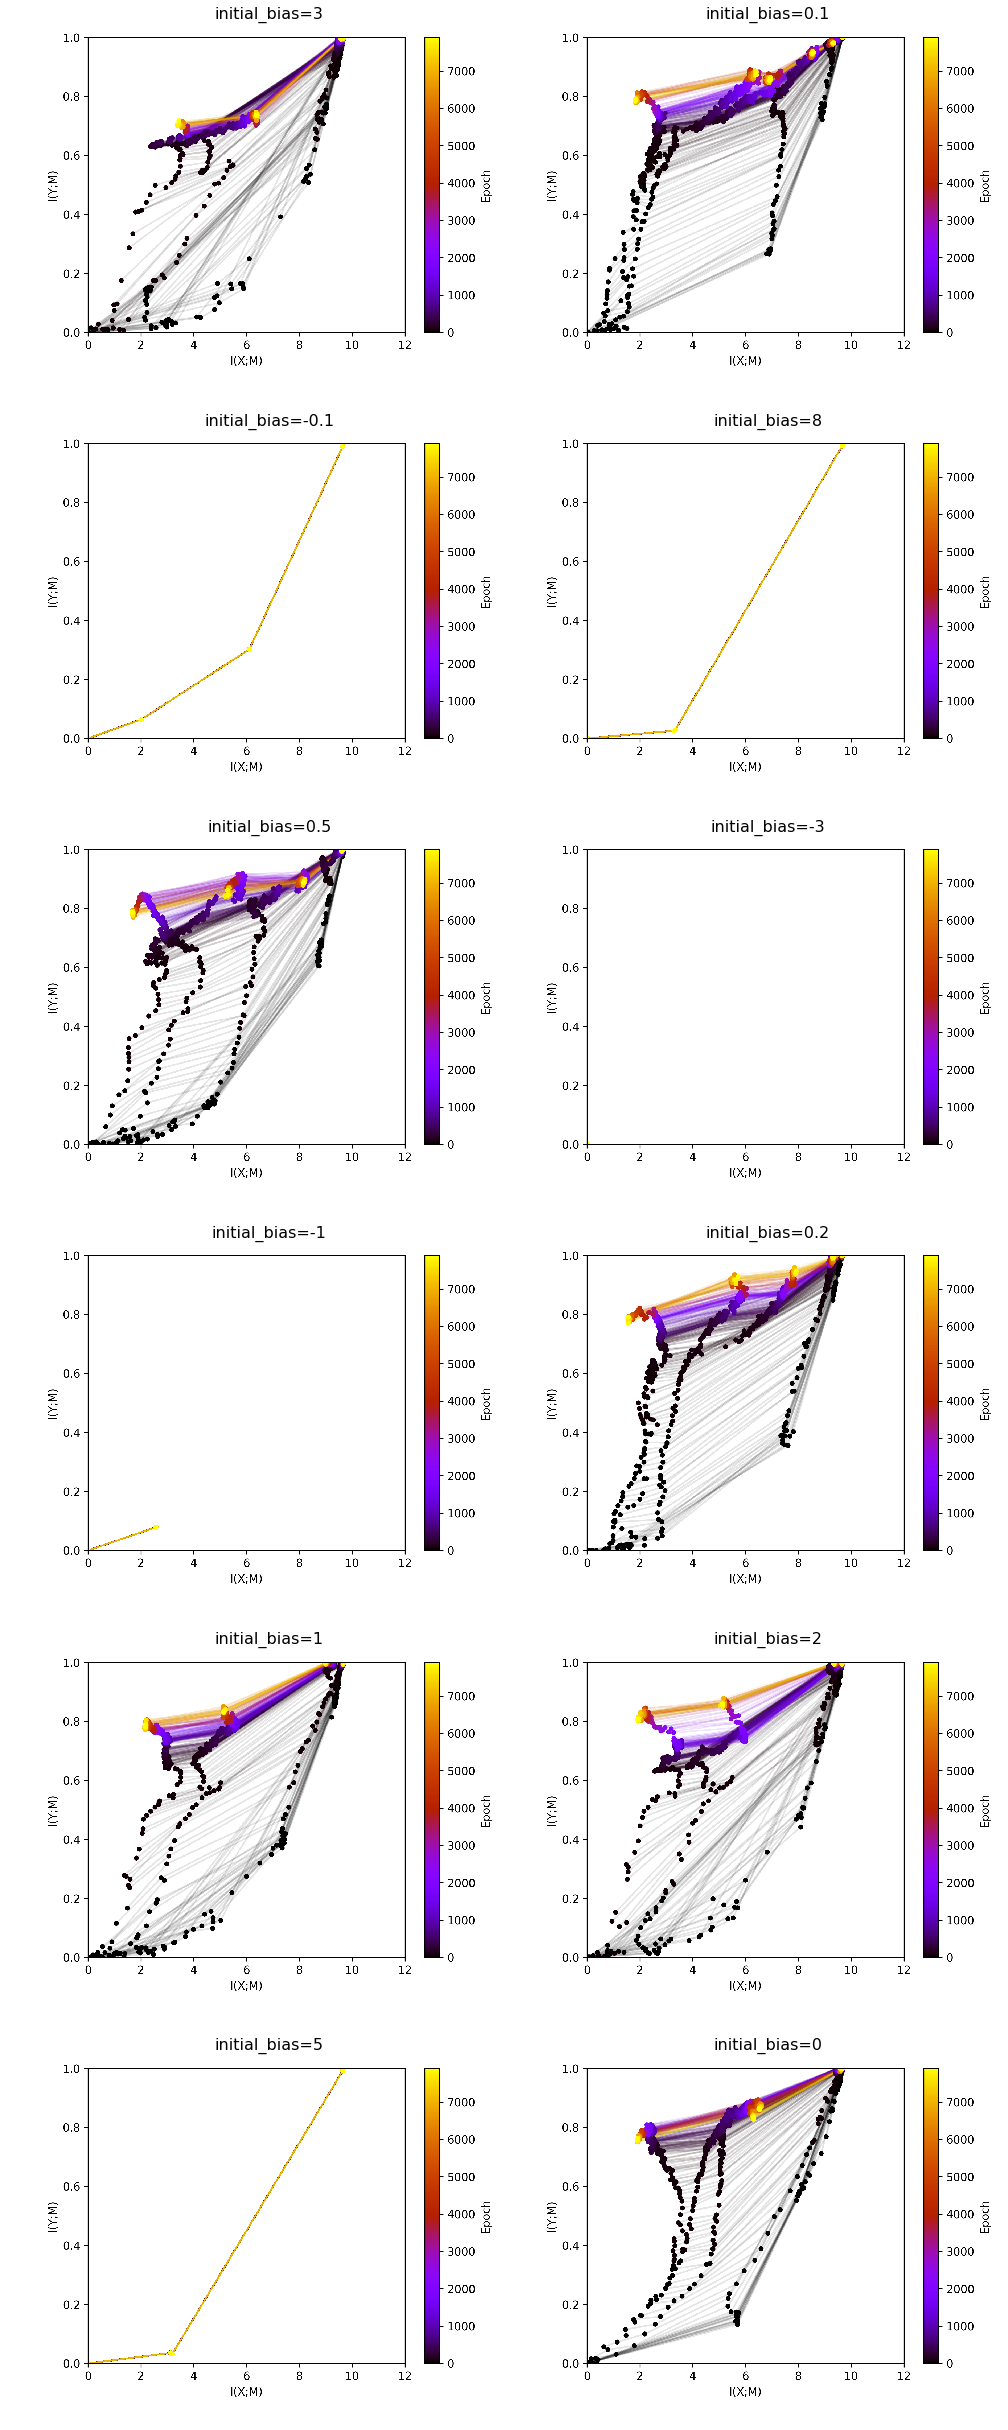

In [6]:
fig, ax = plt.subplots(6,2, figsize=(14, 34))
ax = ax.flat

for i, experiment in enumerate(experiments):
    img = plt.imread(BytesIO(experiment.artifacts['infoplane_test'].content))
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title(format_config(experiment.config, *differing_config_keys),
                    fontsize=16)
plt.tight_layout()    
plt.show()

In the following we will have a close look on the activations of experiment with `initial_bias=2`, experiment_id=865

In [8]:
bias2 = loader.find_by_id(865)
bias2.config

{'activation_fn': 'relu',
 'architecture': [10, 7, 5, 4, 3],
 'batch_size': 256,
 'callbacks': [],
 'dataset': 'datasets.harmonics',
 'discretization_range': 0.07,
 'epochs': 8000,
 'estimator': 'mi_estimator.binning',
 'initial_bias': 2,
 'learning_rate': 0.0004,
 'max_norm_weights': False,
 'model': 'models.feedforward',
 'n_runs': 1,
 'optimizer': 'adam',
 'plotters': [['plotter.informationplane', []],
  ['plotter.snr', []],
  ['plotter.informationplane_movie', []],
  ['plotter.activations', []],
  ['plotter.activations_single_neuron', []]],
 'seed': 0}

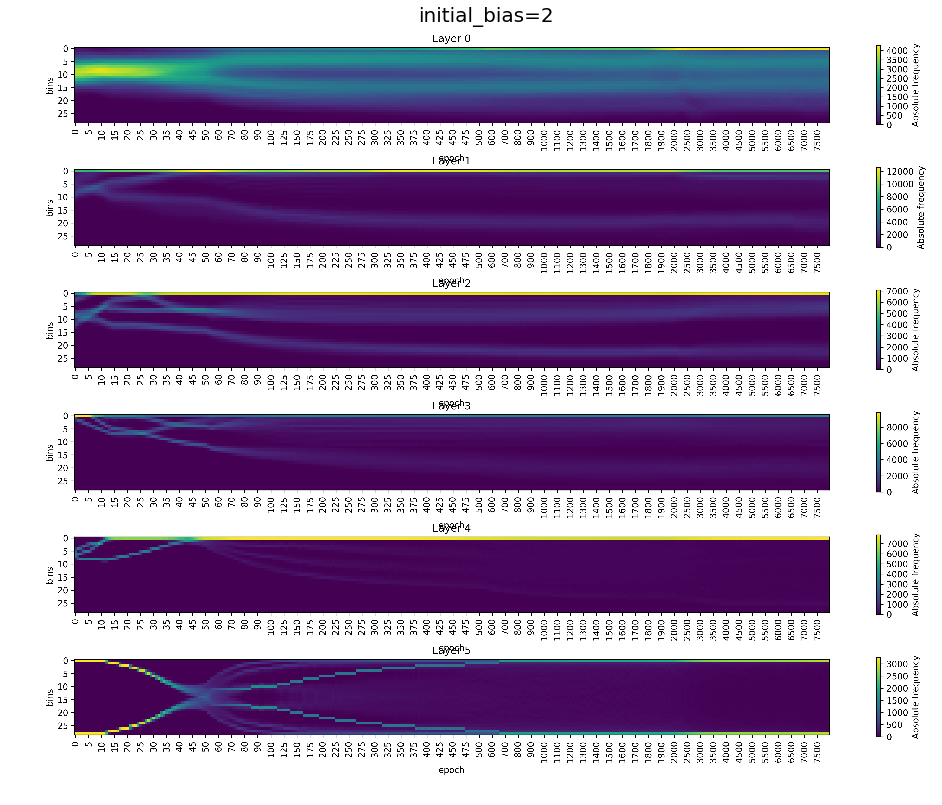

In [13]:
fig, ax = plt.subplots(1,1, figsize=(16, 20))

img = plt.imread(BytesIO(bias2.artifacts['activations_train'].content))
ax.axis('off')
ax.imshow(img)
ax.set_title(format_config(bias2.config, *differing_config_keys),
                fontsize=20)

plt.show()

In [16]:
bias2_multiple = loader.find_by_id(885)
bias2_multiple.config

{'activation_fn': 'tanh',
 'architecture': [10, 7, 5, 4, 3],
 'batch_size': 256,
 'callbacks': [],
 'dataset': 'datasets.harmonics',
 'discretization_range': 0.07,
 'epochs': 8000,
 'estimator': 'mi_estimator.binning',
 'initial_bias': 2,
 'learning_rate': 0.0004,
 'max_norm_weights': False,
 'model': 'models.feedforward',
 'n_runs': 10,
 'optimizer': 'adam',
 'plotters': [['plotter.informationplane', []],
  ['plotter.snr', []],
  ['plotter.informationplane_movie', []],
  ['plotter.activations', []],
  ['plotter.activations_single_neuron', []]],
 'seed': 0}

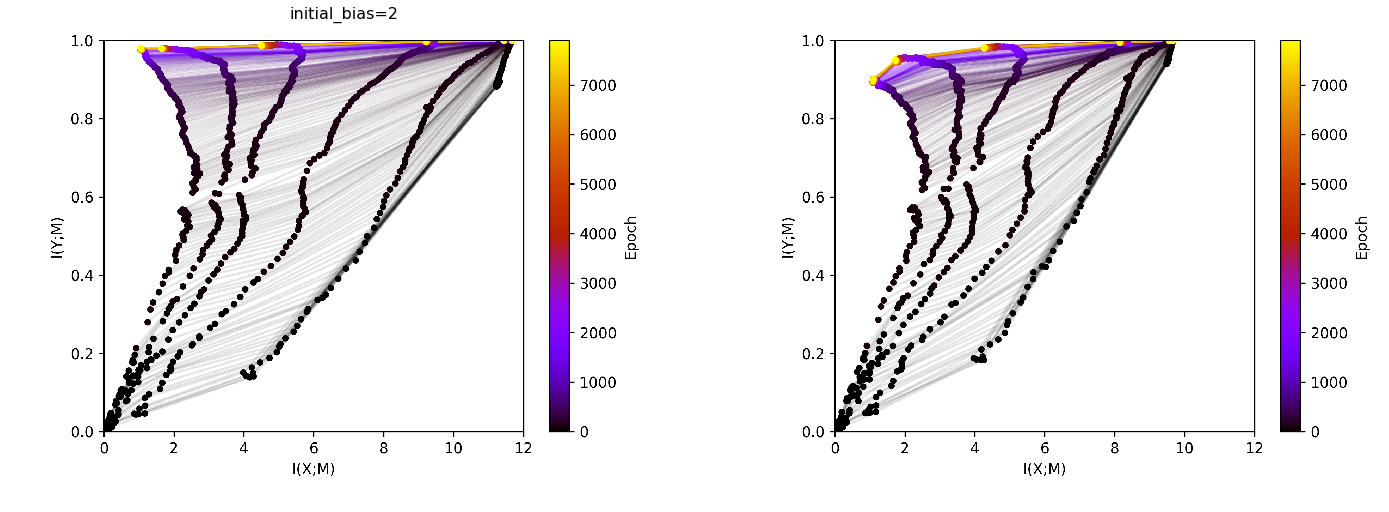

In [20]:
fig, ax = plt.subplots(1,2, figsize=(24, 24))
ax = ax.flat

img_train = plt.imread(BytesIO(bias2_multiple.artifacts['infoplane_train'].content))
ax[0].axis('off')
ax[0].imshow(img_train)
ax[0].set_title(format_config(bias2_multiple.config, *differing_config_keys),
                fontsize=16)
img_test = plt.imread(BytesIO(bias2_multiple.artifacts['infoplane_test'].content))
ax[1].axis('off')
ax[1].imshow(img_test)
plt.show()

## Supplementary material

Below we find plots indicating the development of means and standard deviation of the gradient, its signal to noise ratio as well as the norm of the weight vector for all layers over the course of training. Comparing plots for unconstrained vs. constrained weight vector, we can reassure ourselves that rescaling the weights worked as we expected.

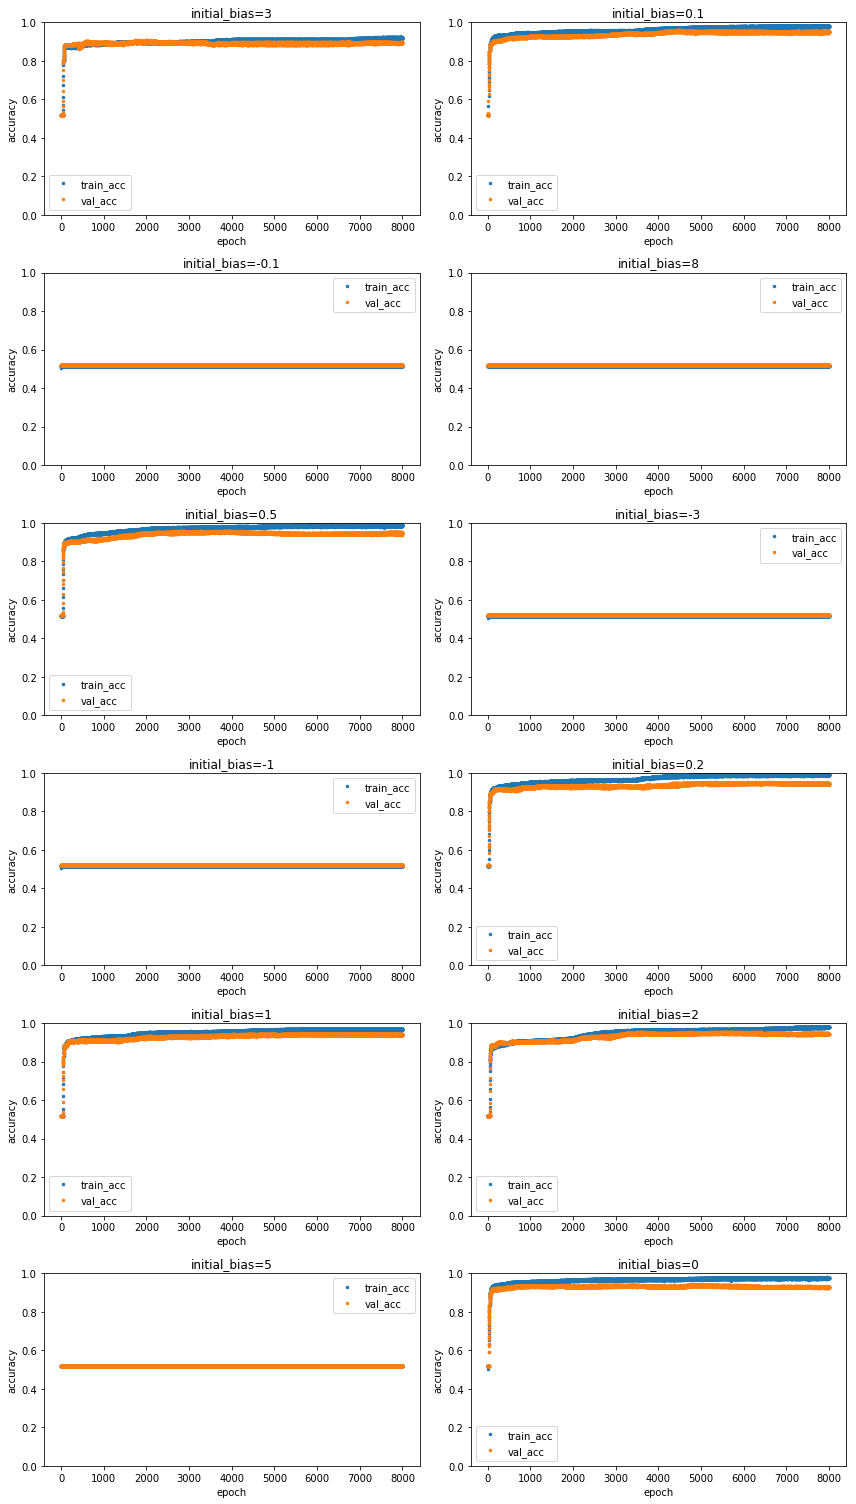

In [21]:
fig, ax = plt.subplots(6,2, figsize=(12, 21))
ax = ax.flat

for i, experiment in enumerate(experiments): 
    df = pd.DataFrame(data=np.array([experiment.metrics['training.accuracy'].values, 
                                     experiment.metrics['test.accuracy'].values]).T,
                  index=experiment.metrics['test.accuracy'].index,
                  columns=['train_acc', 'val_acc'])

    df.plot(linestyle='', marker='.', markersize=5, ax=ax[i])
    ax[i].set_title(format_config(experiment.config, *differing_config_keys),
                    fontsize=12)
    ax[i].set_ylim([0,1])
    ax[i].set(xlabel='epoch', ylabel='accuracy')

plt.tight_layout()    
plt.show()

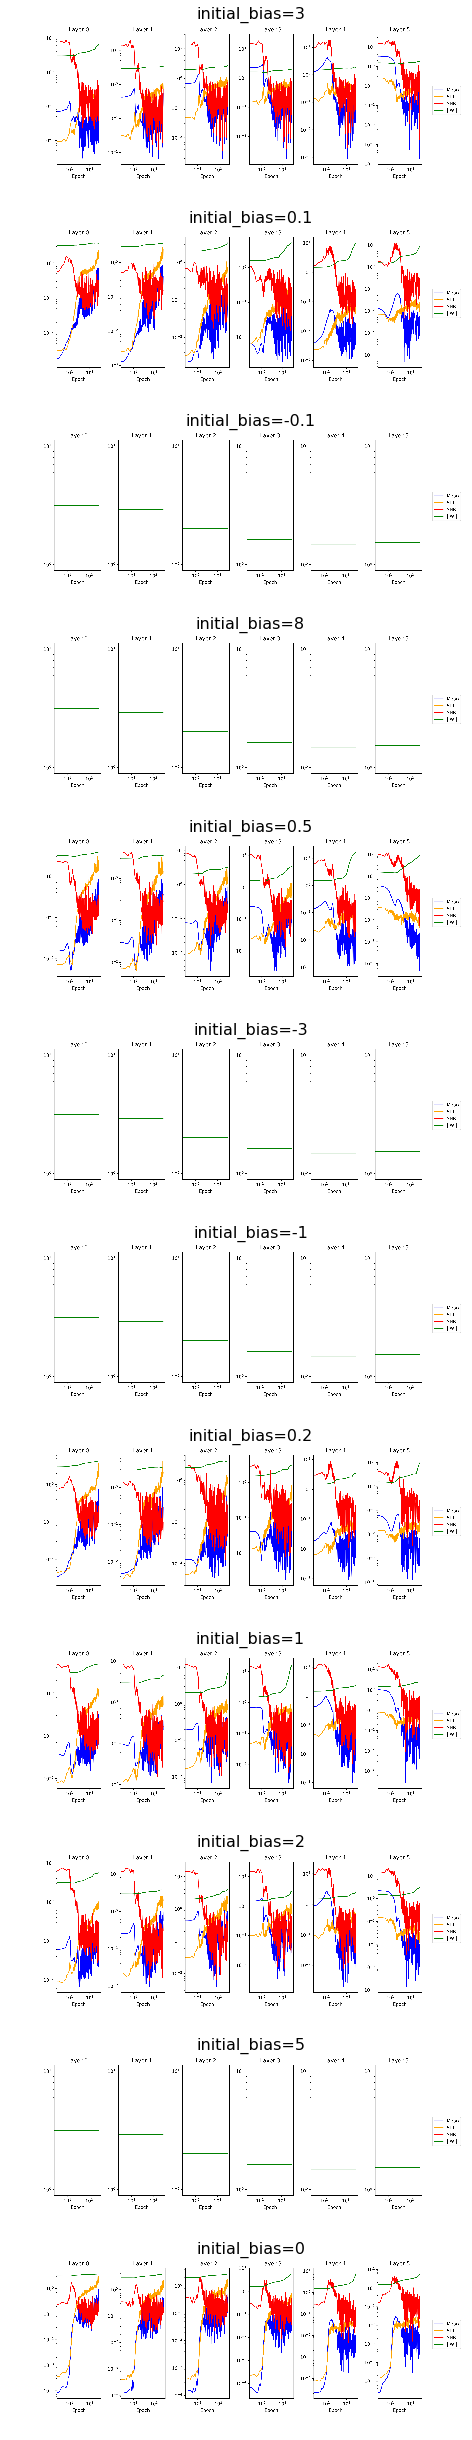

In [22]:
fig, ax = plt.subplots(12,1, figsize=(14, 34))
ax = ax.flat

for i, experiment in enumerate(experiments):
    img = plt.imread(BytesIO(experiment.artifacts['snr_train'].content))
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title(format_config(experiment.config, *differing_config_keys),
                    fontsize=16)
plt.tight_layout()    
plt.show()

In [23]:
variable_config_dict = {k: '<var>' for k in differing_config_keys}
config = experiments[0].config
config.update(variable_config_dict)
config

{'activation_fn': 'relu',
 'architecture': [10, 7, 5, 4, 3],
 'batch_size': 256,
 'callbacks': [],
 'dataset': 'datasets.harmonics',
 'discretization_range': 0.07,
 'epochs': 8000,
 'estimator': 'mi_estimator.binning',
 'initial_bias': '<var>',
 'learning_rate': 0.0004,
 'max_norm_weights': False,
 'model': 'models.feedforward',
 'n_runs': 1,
 'optimizer': 'adam',
 'plotters': [['plotter.informationplane', []],
  ['plotter.snr', []],
  ['plotter.informationplane_movie', []],
  ['plotter.activations', []],
  ['plotter.activations_single_neuron', []]],
 'seed': 0}